# Estimate substitution rate for simulated populations

Estimate the number of amino acid substitutions per year for simulated populations.

In [1]:
from augur.types import ValidationMode
from augur.utils import annotate_parents_for_tree, read_node_data, read_tree
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import seaborn as sns

In [2]:
tree = read_tree("analysis/simulated_substitution_rate/2030-10-01/tree.nwk")

In [3]:
tree = annotate_parents_for_tree(tree)

In [4]:
node_data = read_node_data(
    [
        "analysis/simulated_substitution_rate/2030-10-01/branch_lengths.json",
        "analysis/simulated_substitution_rate/2030-10-01/aa_muts.json",
    ],
    validation_mode=ValidationMode.SKIP,
)

Validating schema of 'analysis/simulated_substitution_rate/2030-10-01/aa_muts.json'...


In [5]:
len(node_data["nodes"])

2317

In [6]:
# Count cumulative mutations per node.
for node in tree.find_clades():
    node_aa_muts = sum(len(muts) for muts in node_data["nodes"][node.name]["aa_muts"].values())
    node.total_aa_muts = getattr(node.parent, "total_aa_muts", 0) + node_aa_muts if node.parent else node_aa_muts

In [7]:
# Get pairs of dates and cumulative mutations.
dates = []
total_aa_muts = []

for node in tree.find_clades():
    dates.append(node_data["nodes"][node.name]["numdate"])
    total_aa_muts.append(node.total_aa_muts)

In [8]:
dates[:5]

[2024.1068478751886,
 2024.1174453250167,
 2024.2365011242416,
 2024.3394541602465,
 2024.8565573770493]

In [9]:
total_aa_muts[:5]

[0, 0, 1, 2, 7]

In [10]:
# Fit linear regression to estimate cumulative AA mutations per year.
slope, intercept, rvalue, pvalue, stderr = linregress(dates, total_aa_muts)

In [11]:
slope

4.030099500285554

In [12]:
intercept

-8154.626213111253

In [13]:
rvalue

0.9671887004936256

In [14]:
rvalue ** 2

0.9354539823625482

In [15]:
stderr

0.022002082210473523

In [16]:
x = np.linspace(min(dates), max(dates) + 1, 100)

In [17]:
y = slope * x + intercept

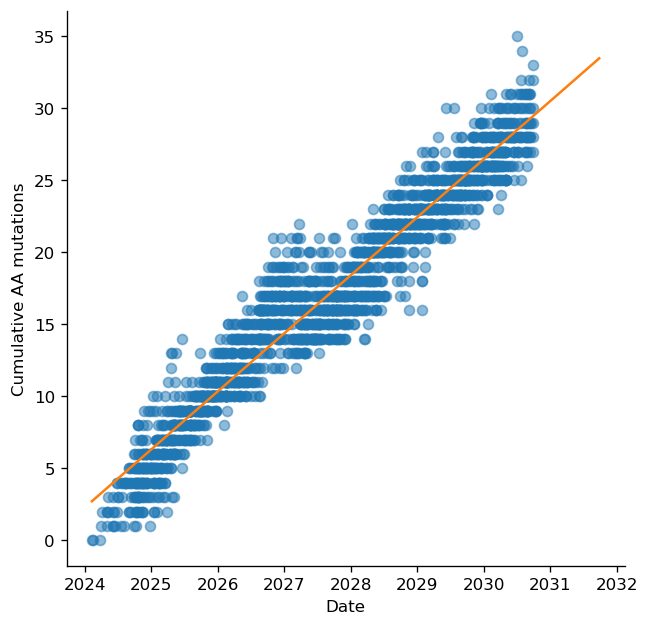

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), dpi=120)
ax.plot(
    dates,
    total_aa_muts,
    "o",
    alpha=0.5,
)

ax.plot(
    x,
    y,
    color="C1",
)

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative AA mutations")
sns.despine()

In [19]:
df = pd.DataFrame({"date": dates, "total_aa_muts": total_aa_muts})

In [20]:
df.head()

,date,total_aa_muts
0,2024.106848,0
1,2024.117445,0
2,2024.236501,1
3,2024.339454,2
4,2024.856557,7


In [21]:
df["year"] = df["date"].astype(int)

In [22]:
range_of_total_aa_muts = np.diff(df.query("year > 2000").groupby("year").agg({"total_aa_muts": ["min", "max"]}))[:, 0]

In [23]:
range_of_total_aa_muts

array([ 9, 12, 13, 10, 12, 14, 12])

In [24]:
range_of_total_aa_muts.mean()

11.714285714285714

In [25]:
range_of_total_aa_muts.min()

9

In [26]:
range_of_total_aa_muts.max()

14